# Lab 5 - Using link functions to create generalized linear models

We consider the dataset from the lecture considering Airline accidents and deaths.
Now the dataset is provided in ```Airline_data.csv``` file and you can create your own model. This time you dont get a jupyter notebook to fill so create your own. 

During the lecture we have tried Poisson models with varying degrees of success. Our considered models were (assuming $y_i$ is the number of accidents in given year):
- $y_i\sim\mathrm{Poisson}(\lambda)$ that is one fixed $\lambda$ for all years i.e. number of accidents is random independent on year where it happens
-  $y_i\sim\mathrm{Poisson}(\theta n_i)$ where $n_i$ is the ammount of miles flown that year. 

We will now try to improve upon those models using new structures and parameters. Lets add an additional mean ammount of accidents i.e model with intercept $\lambda_i=\alpha+\theta n_i$. This might be problematic, as coefficient $\lambda$ has to be positive, without appropriate carefulness it could create errors in sampling. Typical approach is to use a *link function*, i.e. function that would transform domain of parameter to one that is applicable. For Poisson distributions it is popular to use logarithm:

$$\log \lambda_i=\alpha+\theta n_i$$

which translates to the following sampling statement

$$ y_i\sim\mathrm{Poisson}(\underbrace{\exp(\alpha+\theta n_i)}_{\lambda_i})$$

Create such model and perform prior predictive analysis to choose priors. 

**Important** chose priors wisely, as exponential function can become quite large and return errors in sampling when it becomes too big. Perhaps before sampling of Poisson try to find what kind of values for $\lambda_i$ come from priors. 

After testing priors fit the model to data and evaluate its efficiency by by posterior predictive distribution and comparing histograms of accidents for entire period and for each year.

Try to improve the model by replacing single intercept $\alpha$ with individual intercepts of $\alpha_i$ for each year. It can be easily done, by declaring $\alpha$ as an array of appropriate dimension. Then only one prior is needed as it will be used for all the elements of the array.

Again perform the prior predictive distribution analysis to select prior parameters, fit the model and analyze its output. 



In [7]:
from cmdstanpy import CmdStanModel
import pandas as pd
import arviz as az 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [8]:
pd_data = pd.read_csv('Airline_data.csv')
print(pd_data)
print(pd_data.describe())

   Year  Fatal accidents  Passenger deaths  Miles flown [100 mln miles]
0  1976               24               734                       3863.0
1  1977               25               516                       4300.0
2  1978               31               754                       5027.0
3  1979               31               877                       5481.0
4  1980               22               814                       5814.0
5  1981               21               362                       6033.0
6  1982               26               764                       5877.0
7  1983               20               809                       6223.0
8  1984               16               223                       7433.0
9  1985               22              1066                       7107.0
             Year  Fatal accidents  Passenger deaths  \
count    10.00000        10.000000         10.000000   
mean   1980.50000        23.800000        691.900000   
std       3.02765         4.709329      

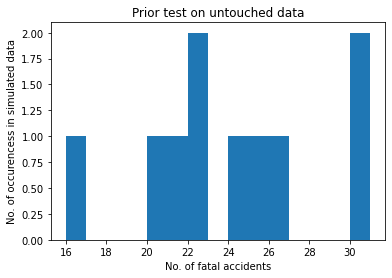

In [9]:
pd_data['Fatal accidents'].plot.hist(bins=15)
plt.title("Prior test on untouched data")
plt.xlabel("No. of fatal accidents")
plt.ylabel("No. of occurencess in simulated data")
plt.show()

Prior

Data is scaled so i would fit model better

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing


normalized miles : 0   -1.8528
1   -1.4158
2   -0.6888
3   -0.2348
4    0.0982
5    0.3172
6    0.1612
7    0.5072
8    1.7172
9    1.3912
Name: Miles flown [normalized], dtype: float64


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


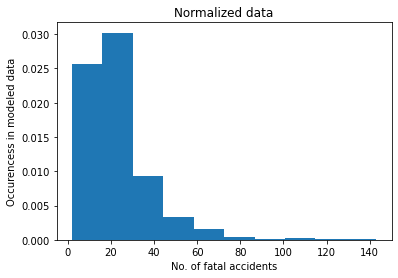

In [10]:

pd_data = pd.read_csv('Airline_data.csv')
pd_data["Miles flown [normalized]"] = pd_data["Miles flown [100 mln miles]"] /1000
pd_data["Miles flown [normalized]"] = pd_data["Miles flown [normalized]"] - pd_data["Miles flown [normalized]"].mean()
print(f'''normalized miles : {pd_data["Miles flown [normalized]"]}''')


tuning=CmdStanModel(stan_file='code_1.stan')
data_fit = {'alpha_mean': 3, 'alpha_std': 0.1, 'theta_mean': 0.5, 'theta_std': 0.1,'miles_mean': 0, 'miles_std':1 }
R=1000
tuned = tuning.sample(seed=13042023,
                      data=data_fit,
                      fixed_param=True,
                      iter_sampling=R, 
                      iter_warmup=0,
                      chains=1)
experiment = tuned.draws_pd()
experiment.describe()
experiment['y_sim'].plot.hist(density=True)
plt.title("Normalized data")
plt.xlabel("No. of fatal accidents")
plt.ylabel("Occurencess in modeled data")
plt.show()

Posterior

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


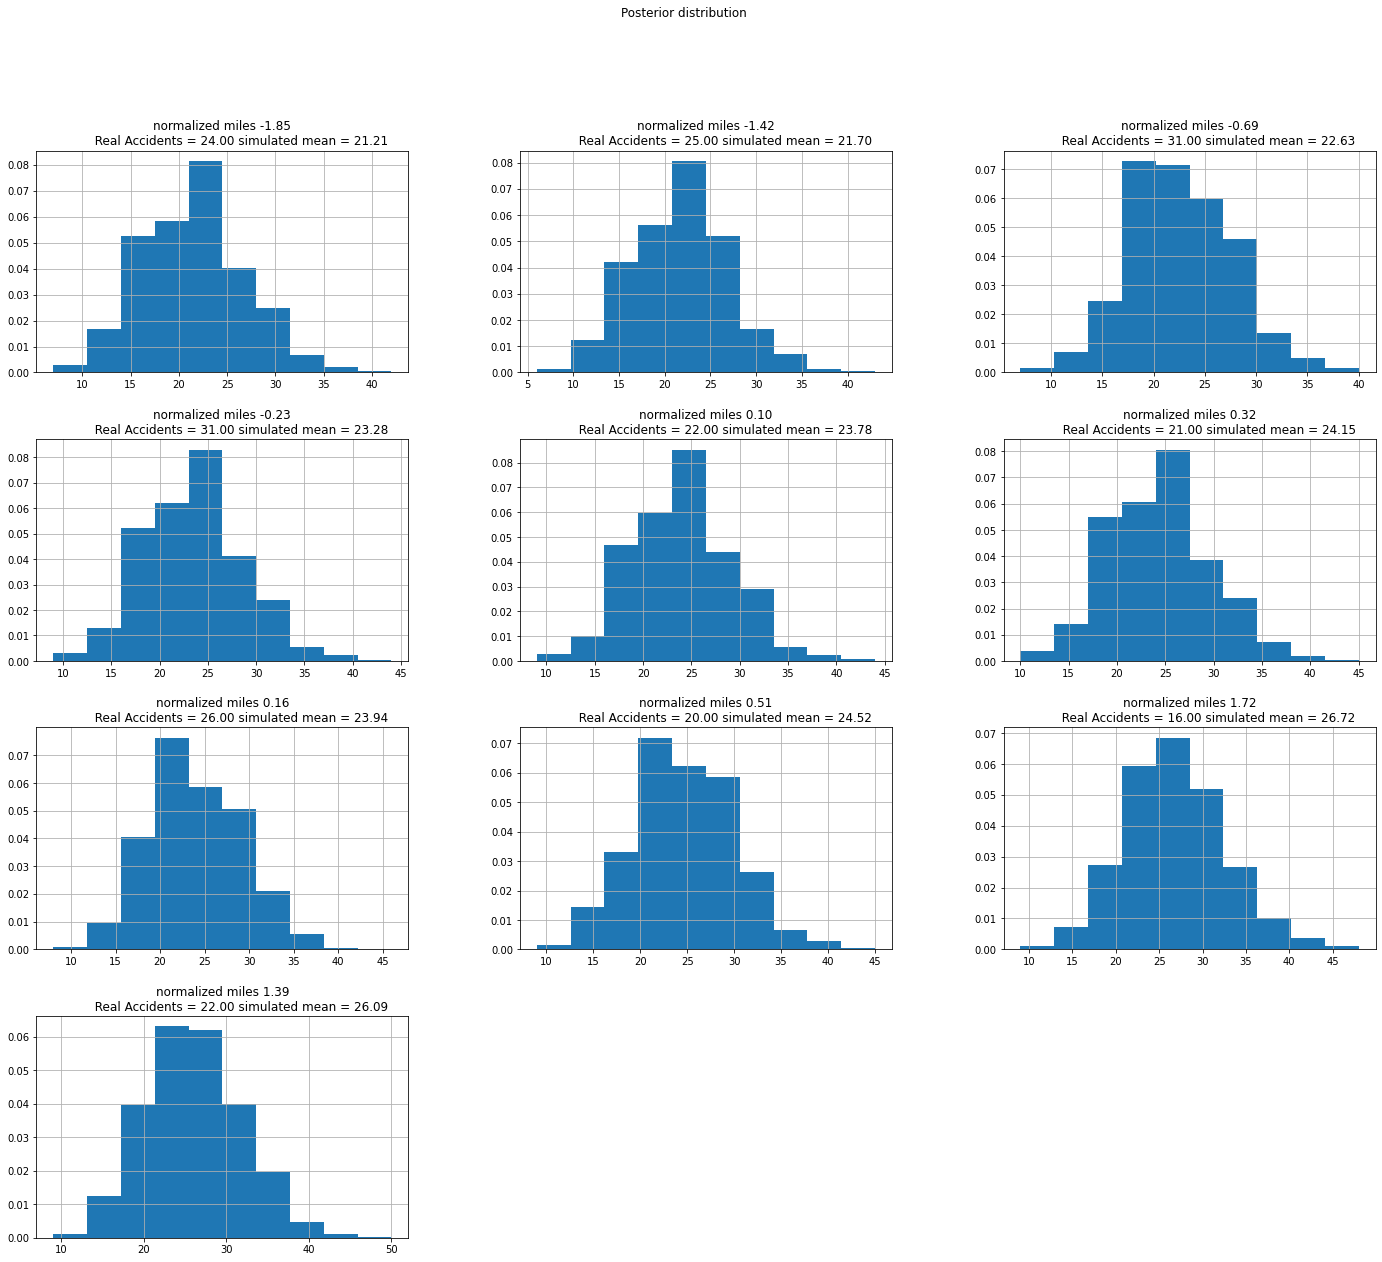

          y_sim[1]     y_sim[2]     y_sim[3]     y_sim[4]     y_sim[5]  \
count  4000.000000  4000.000000  4000.000000  4000.000000  4000.000000   
mean     21.207250    21.702000    22.626750    23.276750    23.782000   
std       5.292807     5.179711     5.070588     5.089611     5.144812   
min       7.000000     6.000000     7.000000     9.000000     9.000000   
25%      17.000000    18.000000    19.000000    20.000000    20.000000   
50%      21.000000    22.000000    22.500000    23.000000    24.000000   
75%      25.000000    25.000000    26.000000    27.000000    27.000000   
max      42.000000    43.000000    40.000000    44.000000    44.000000   

         y_sim[6]     y_sim[7]     y_sim[8]     y_sim[9]    y_sim[10]  
count  4000.00000  4000.000000  4000.000000  4000.000000  4000.000000  
mean     24.14775    23.940250    24.521500    26.722000    26.085250  
std       5.24860     5.061085     5.304816     5.953871     5.698693  
min      10.00000     8.000000     9.000000  

In [11]:
posterior=CmdStanModel(stan_file='code_2.stan')

data_fit = {'alpha_mean': 3, 'alpha_std': 1, 'theta_mean': 0.5, 'theta_std': 0.1,
    "M": len(pd_data), "miles": pd_data["Miles flown [normalized]"].values, "y": pd_data["Fatal accidents"].values}

posterior_one = posterior.sample(seed=13042023,
                      data=data_fit)
posterior_one_pd = posterior_one.draws_pd()
#print(posterior_one_pd)

axes = posterior_one_pd.iloc[:,19:].hist(figsize=(24,20), density=True)
axes = axes.ravel()
for idx,ax in enumerate(axes):
    if idx < 10:
        temp = f'y_sim[{idx+1}]'
        temp_2 = posterior_one_pd[temp].mean()
        ax.set_title(f'''normalized miles {pd_data['Miles flown [normalized]'][idx]:.2f}
          Real Accidents = {pd_data['Fatal accidents'][idx]:.2f} simulated mean = {temp_2:.2f}''')
plt.suptitle("Posterior distribution")

plt.show()
print(posterior_one_pd.iloc[:,19:].describe())

Right now simulated data is similar for each year, and therefore the fit is not so precise

INFO:cmdstanpy:compiling stan file /root/ISZ_DA/Lab_05/code_3.stan to exe file /root/ISZ_DA/Lab_05/code_3
INFO:cmdstanpy:compiled model executable: /root/ISZ_DA/Lab_05/code_3

--- Translating Stan model to C++ code ---
bin/stanc  --o=/root/ISZ_DA/Lab_05/code_3.hpp /root/ISZ_DA/Lab_05/code_3.stan
Warning in '/root/ISZ_DA/Lab_05/code_3.stan', line 3, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/root/ISZ_DA/Lab_05/code_3.stan', line 4, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/root/ISZ_DA/Lab_05/code_3.stan', line 12, column 3: Declaration
    

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


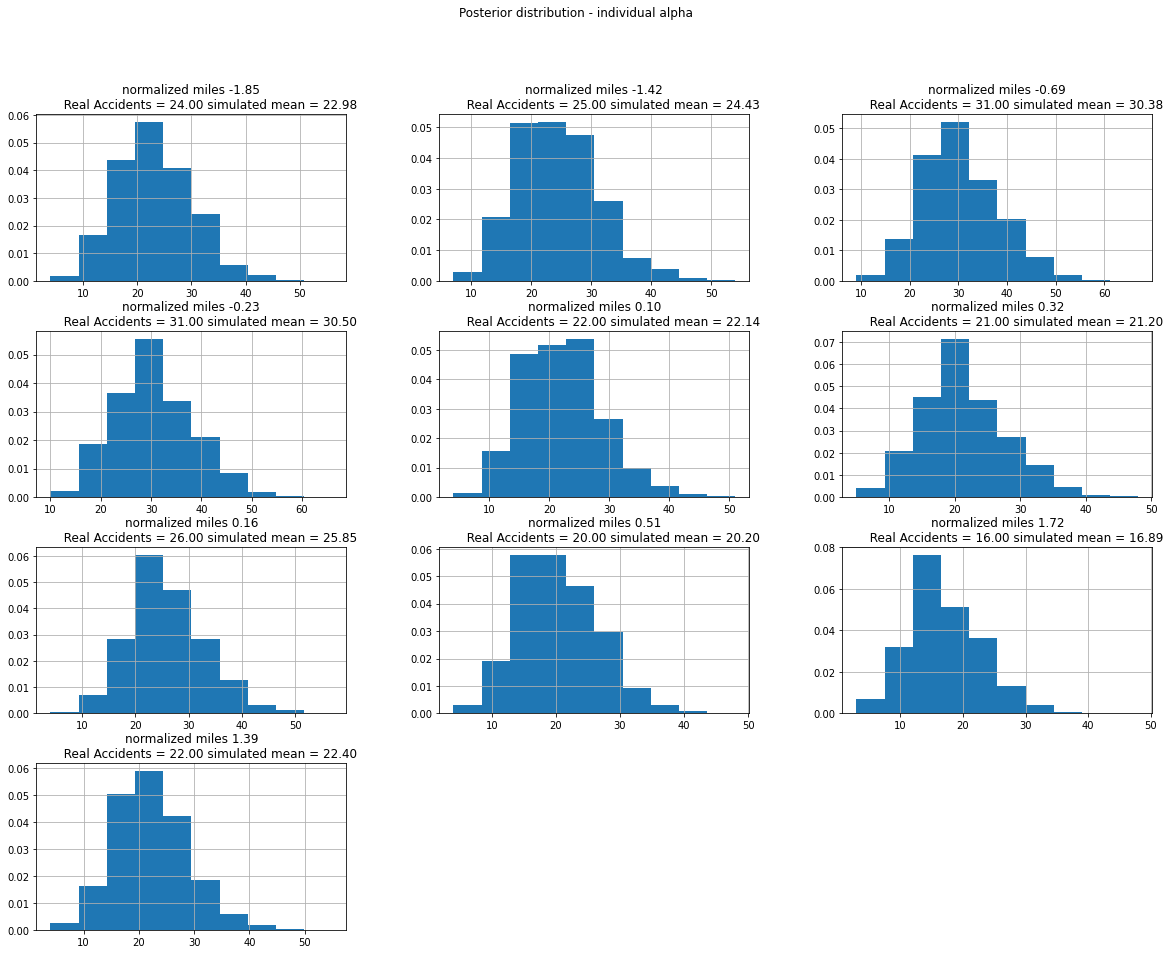

          y_sim[1]     y_sim[2]     y_sim[3]    y_sim[4]     y_sim[5]  \
count  4000.000000  4000.000000  4000.000000  4000.00000  4000.000000   
mean     22.978500    24.427000    30.377500    30.50175    22.143000   
std       6.719474     6.770756     7.857762     7.81737     6.652113   
min       4.000000     7.000000     9.000000    10.00000     4.000000   
25%      18.000000    20.000000    25.000000    25.00000    17.000000   
50%      22.000000    24.000000    30.000000    30.00000    22.000000   
75%      27.000000    29.000000    35.000000    35.00000    26.000000   
max      56.000000    54.000000    67.000000    66.00000    51.000000   

         y_sim[6]     y_sim[7]     y_sim[8]     y_sim[9]    y_sim[10]  
count  4000.00000  4000.000000  4000.000000  4000.000000  4000.000000  
mean     21.19725    25.851000    20.203500    16.892000    22.396000  
std       6.47988     7.151334     6.230352     5.814102     6.462478  
min       5.00000     4.000000     4.000000     3.0000

In [12]:
posterior=CmdStanModel(stan_file='code_3.stan')

data_fit = {'alpha_mean': 3, 'alpha_std': 1, 'theta_mean': 0.5, 'theta_std': 0.1,
    "M": len(pd_data), "miles": pd_data["Miles flown [normalized]"].values, "y": pd_data["Fatal accidents"].values}

posterior_multi = posterior.sample(seed=13042023,
                      data=data_fit)
posterior_multi_pd = posterior_multi.draws_pd()


axes = posterior_multi_pd.iloc[:,-10:].hist(figsize=(20,15), density=True)
axes = axes.ravel()
for idx,ax in enumerate(axes[0:10]):
        temp = f'y_sim[{idx+1}]'
        temp_2 = posterior_multi_pd[temp].mean()
        ax.set_title(f'''normalized miles {pd_data['Miles flown [normalized]'][idx]:.2f}
          Real Accidents = {pd_data['Fatal accidents'][idx]:.2f} simulated mean = {temp_2:.2f}''')
plt.suptitle("Posterior distribution - individual alpha")

plt.show()
print(posterior_multi_pd.iloc[:,-10:].describe())

After selecting individual alpha parameters, the model fits the data much better.